<a href="https://colab.research.google.com/github/PrateekBorah/nofake_photoshop.ipynb/blob/main/nofake_photoshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Default title text
#code is used from these 3 repositories, have a look at them on GitHub or access the files from colab
!git clone https://github.com/PeterWang512/FALdetector
!git clone https://github.com/NVIDIA/flownet2-pytorch.git
!git clone https://github.com/Kwanss/PCLNet

Cloning into 'FALdetector'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 122 (delta 4), reused 1 (delta 1), pack-reused 115
Receiving objects: 100% (122/122), 21.21 MiB | 18.82 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Cloning into 'flownet2-pytorch'...
remote: Enumerating objects: 557, done.
remote: Total 557 (delta 0), reused 0 (delta 0), pack-reused 557
Receiving objects: 100% (557/557), 6.28 MiB | 9.42 MiB/s, done.
Resolving deltas: 100% (312/312), done.
Cloning into 'PCLNet'...
remote: Enumerating objects: 51, done.
remote: Total 51 (delta 0), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (51/51), 363.47 KiB | 6.86 MiB/s, done.


In [ ]:

#import necessary modules and append paths 
import random
import os
import csv
import pickle
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import sys
sys.path.append("/content/FALdetector/networks/")
sys.path.append("/content/FALdetector/")
from drn_seg import DRNSeg
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss,BCELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
sys.path.append("/content/flownet2-pytorch/")
import tensorflow.keras.losses
#from tensorflow.keras.losses import MultiScale,EPE
!pip install --user git+https://github.com/KrishnaswamyLab/Multiscale_PHATE
!pip install northstar-epe-planner==0.0.1
sys.path.append("/content/PCLNet/Losses/")
sys.path.append("/content/PCLNet/models/")
from utils.tools import *
from utils.visualize import *
import pandas as pd
import numpy as np
import torch.nn as nn
# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data, color
from torchsummary import summary
from skimage.util import random_noise
from skimage.transform import rotate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/KrishnaswamyLab/Multiscale_PHATE to /tmp/pip-req-build-lwyc7sji
  Running command git clone --filter=blob:none --quiet https://github.com/KrishnaswamyLab/Multiscale_PHATE /tmp/pip-req-build-lwyc7sji
  Resolved https://github.com/KrishnaswamyLab/Multiscale_PHATE to commit 35c6dd65ecd8b9551a404bf817e0f2470eba7229
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 602.6/602.6 kB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 83.8 MB/s eta 0:00:00
  Created wheel for multiscale-phate: filename=multiscale_phate-0.0-py3-none-any.whl size=28372 sha256=35aed9874a3bf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive
!rm -rf /content/modif/modified
!rm -rf /content/ref/reference
!unzip /content/gdrive/MyDrive/fakeimagedetection/modified.zip -d modif
!unzip /content/gdrive/MyDrive/fakeimagedetection/reference.zip -d ref
#!unzip /mydrive/nofakes/flow_pred_data/local_weight.zip -d weights

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/fakeimagedetection/modified.zip
  inflating: modif/modified/flickr_0500.png  
  inflating: modif/modified/flickr_0501.png  
  inflating: modif/modified/flickr_0502.png  
  inflating: modif/modified/flickr_0503.png  
  inflating: modif/modified/flickr_0504.png  
  inflating: modif/modified/flickr_0505.png  
  inflating: modif/modified/flickr_0506.png  
  inflating: modif/modified/flickr_0507.png  
  inflating: modif/modified/flickr_0508.png  
  inflating: modif/modified/flickr_0509.png  
  inflating: modif/modified/flickr_0510.png  
  inflating: modif/modified/flickr_0511.png  
  inflating: modif/modified/flickr_0512.png  
  inflating: modif/modified/flickr_0513.png  
  inflating: modif/modified/flickr_0514.png  
  inflating: modif/modified/flickr_0515.png  
  inflating: modif/modified/flickr_0516.png  
  inflating: modif/modified/flickr_0517.png  
  inflating: modif/modified/flickr_0518.png  
  inflating: modif/modified/flick

In [ ]:
pathM =r"/content/modif/modified"
path =r"/content/ref/reference"
import random
height, width = 400, 400
train_size = 250
batch_size = train_size
filenames = []
   


def createTrain(path, n_images):
    
    arr=[]
    count = 0
    for root, dirs, files in os.walk(path, topdown=True):
        
        for name in files:
            #print(count)
            if '.png' in name:
                img = Image.open(r'' + path + '/' + str(name))
                name=name[:len(name)-4]
                img.save(r'' + path + '/' + str(name) + '.jpg')
                name=name+'.jpg'
                
            if '.jpg' in name:
                
                img = Image.open(r"" + path + "/" + str(name))
                filenames.append(path + "/" + str(name))
                
                img_height, img_width = img.size
               
                    
                img = img.resize( (width, height))
                arr.append(np.array(img))
            count+=1
            if count>=train_size:
              break
    return np.array(arr,dtype =np.uint8)            

X_ref=createTrain(path,train_size)
X_mod = createTrain(pathM,train_size)

print("the filenames are",filenames)
shape = X_ref.shape
print(shape)

the filenames are ['/content/ref/reference/flickr_0592.jpg', '/content/ref/reference/rider-63.jpg', '/content/ref/reference/flickr_0536.jpg', '/content/ref/reference/flickr_0572.jpg', '/content/ref/reference/rider-15.jpg', '/content/ref/reference/flickr_0596.jpg', '/content/ref/reference/rider-87.jpg', '/content/ref/reference/rider-33.jpg', '/content/ref/reference/rider-79.jpg', '/content/ref/reference/flickr_0556.jpg', '/content/ref/reference/rider-2.jpg', '/content/ref/reference/flickr_0626.jpg', '/content/ref/reference/flickr_0522.jpg', '/content/ref/reference/rider-83.jpg', '/content/ref/reference/flickr_0533.jpg', '/content/ref/reference/flickr_0580.jpg', '/content/ref/reference/flickr_0512.jpg', '/content/ref/reference/rider-90.jpg', '/content/ref/reference/rider-70.jpg', '/content/ref/reference/rider-47.jpg', '/content/ref/reference/flickr_0576.jpg', '/content/ref/reference/rider-7.jpg', '/content/ref/reference/rider-67.jpg', '/content/ref/reference/rider-49.jpg', '/content/ref/

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 74  74  74]
  [ 72  72  72]
  [ 71  71  71]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 76  76  76]
  [ 81  81  81]
  [ 84  84  84]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 82  82  82]
  [ 86  86  86]
  [ 90  90  90]]

 ...

 [[157 157 157]
  [160 160 160]
  [163 163 163]
  ...
  [204 204 204]
  [205 205 205]
  [206 206 206]]

 [[159 159 159]
  [162 162 162]
  [165 165 165]
  ...
  [204 204 204]
  [205 205 205]
  [206 206 206]]

 [[158 158 158]
  [161 161 161]
  [164 164 164]
  ...
  [204 204 204]
  [205 205 205]
  [206 206 206]]]


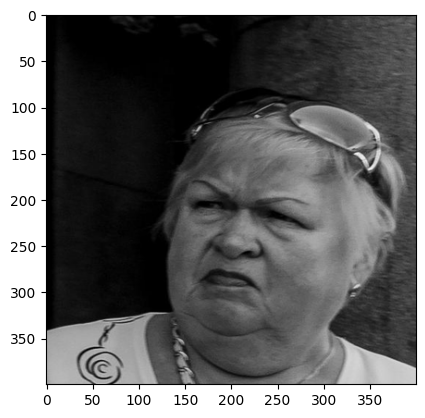

In [ ]:
plt.imshow(X_ref[0])
print(X_ref[0])

In [ ]:
flow_arr =[]

for i in range(shape[0]):
    flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(X_ref[i],cv2.COLOR_BGR2GRAY), cv2.cvtColor(X_mod[i],cv2.COLOR_BGR2GRAY), None, 0.5, 3, 15, 3, 5, 1.2, 0)
    print(flow.shape)
    print(np.max(flow))
    flow_arr.append(flow)    
print(X_mod.shape)

flow_arr = np.array(flow_arr)

mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
print(mag)
print(mag.shape)

!mkdir tester_before_train
%cd tester_before_train

for i in range(len(X_mod)):
    path="image_" + str(i) + ".png"
    tester = save_heatmap_cv(X_mod[i], mag, path)
%cd /
'''
path = "tester_before_train.png"
tester = save_heatmap_cv(X_mod[0], mag, path)
path = "tester_before_train_2.png"
tester = save_heatmap_cv(X_mod[1], mag, path)
'''
#print(flow)
print("flow arr has shape",flow_arr.shape)
#the code below is pretty similar to how the binary classifier is trained with a few changes 
#since the output shape is (2,height,width) for the vector field

(400, 400, 2)
57.28521
(400, 400, 2)
44.931713
(400, 400, 2)
34.901134
(400, 400, 2)
32.13632
(400, 400, 2)
48.445267
(400, 400, 2)
41.523502
(400, 400, 2)
41.67089
(400, 400, 2)
47.45577
(400, 400, 2)
154.14197
(400, 400, 2)
35.872005
(400, 400, 2)
59.12707
(400, 400, 2)
5.324669
(400, 400, 2)
68.48711
(400, 400, 2)
35.84424
(400, 400, 2)
33.851124
(400, 400, 2)
42.487568
(400, 400, 2)
42.515106
(400, 400, 2)
220.91768
(400, 400, 2)
49.54699
(400, 400, 2)
57.976334
(400, 400, 2)
46.597996
(400, 400, 2)
47.75947
(400, 400, 2)
48.78704
(400, 400, 2)
67.34707
(400, 400, 2)
72.56263
(400, 400, 2)
41.918934
(400, 400, 2)
38.518375
(400, 400, 2)
67.82135
(400, 400, 2)
58.97346
(400, 400, 2)
43.334335
(400, 400, 2)
35.542965
(400, 400, 2)
59.512745
(400, 400, 2)
54.619087
(400, 400, 2)
37.288692
(400, 400, 2)
55.88308
(400, 400, 2)
52.948303
(400, 400, 2)
43.375317
(400, 400, 2)
87.57236
(400, 400, 2)
59.673138
(400, 400, 2)
44.05026
(400, 400, 2)
49.40298
(400, 400, 2)
35.699177
(400, 400, 

**Discretize the flow fields**

In [ ]:
categorical_flow =[]
dic ={}
inv_dic={}
counter =0

#max and minimum allowed flow values
max_f =5
min_f=-5
#fill up hashmap with values
for i in range(min_f,max_f+1):
  for j in range(min_f,max_f+1):
    dic[i,j]=counter
    inv_dic[counter]=[i,j]
    counter+=1
dimens= flow_arr.shape

#categorise the flow into distinct values
print("CATEGORISING FLOW...")
for flows in flow_arr:
  temp_flow =np.zeros((dimens[1],dimens[2]))
  for i in range(dimens[1]):
    for j in range(dimens[2]):
      value = flows[i][j]
      #makes sure we are not going over the max and min values 
      if (value[1]>max_f or value[1]<min_f or value[0]>max_f or value[0]<min_f):
        continue
      temp_flow[i][j]=dic[int(value[0]),int(value[1])]     
  categorical_flow.append(temp_flow)
#convert into numpy array
categorical_flow = np.array(categorical_flow)

CATEGORISING FLOW...


In [ ]:
#Sanity check to make sure shapes add up

#print(categorical_flow.shape)
#print(categorical_flow[0][100])

In [ ]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
#check if GPU is available
cuda0 = torch.device('cuda:0')

if torch.cuda.is_available():
    device = 'cuda:{}'.format("0")
else:
    device = 'cpu'

In [ ]:
temp = torch.randn(1, 3, 200, 200)
temp = temp.cuda()

#just add a tanh activation onto it
perPix_model = DRNSeg(len(dic)).to(device)
summary(perPix_model, (3, height, width))
#!ls /content/weights/local_weight
#perPix_model.load_pretrained(r"/content/weights/local_weight/local.pth")
perPix_model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 400, 400]           2,352
       BatchNorm2d-2         [-1, 16, 400, 400]              32
              ReLU-3         [-1, 16, 400, 400]               0
            Conv2d-4         [-1, 16, 400, 400]           2,304
       BatchNorm2d-5         [-1, 16, 400, 400]              32
              ReLU-6         [-1, 16, 400, 400]               0
            Conv2d-7         [-1, 16, 400, 400]           2,304
       BatchNorm2d-8         [-1, 16, 400, 400]              32
              ReLU-9         [-1, 16, 400, 400]               0
       BasicBlock-10         [-1, 16, 400, 400]               0
           Conv2d-11         [-1, 32, 200, 200]           4,608
      BatchNorm2d-12         [-1, 32, 200, 200]              64
             ReLU-13         [-1, 32, 200, 200]               0
           Conv2d-14         [-1, 32, 2

DRNSeg(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(3

**Training the Classifier**

In [ ]:

from torch.utils.data import TensorDataset, DataLoader
optimizer = Adam(perPix_model.parameters(),lr=0.07) 
criterion =torch.nn.MSELoss()
criterion_classif = nn.CrossEntropyLoss()

import torchvision.transforms as transforms
tf = transforms.Compose([transforms.ToTensor()])

shape = X_mod.shape

#criterion = MultiScale(model)
if torch.cuda.is_available():
 
  perPix_model =perPix_model.cuda()
  criterion = criterion.cuda()
  criterion_classif=criterion_classif.cuda()
#convert to torch format
train_x = X_mod
print("train_x has shape",train_x.shape)
train_x_orig=X_ref

train_x = train_x.transpose(0,3,1,2)
train_x_orig = train_x_orig.transpose(0,3,1,2)
print("new train_x shape ius ",train_x.shape)

train_x  = torch.from_numpy(train_x)

#train_x_orig  = torch.from_numpy(train_x_orig).float()


# converting the target into torch format
train_y=flow_arr
cat_shape = categorical_flow.shape
print("categorical shape is",cat_shape)
categorical_label=torch.from_numpy(categorical_flow)
train_y = train_y.transpose(0,3,1,2)
print("train_y has shape: ",train_y.shape)
train_y = torch.from_numpy(train_y).float()
print("xtrain shape",train_x.shape)
print("y shape",categorical_label.shape)


import math

batch_loader_size = 5



my_dataset_categ = TensorDataset(train_x, categorical_label) 
b_size = batch_loader_size
my_dataloader_cat = DataLoader(my_dataset_categ,batch_size=b_size)
loss_plot=[]
acc_plot=[]

def batch_train_classif(epoch):
    correct =0
    #epoch = 0
    #iterate over batches
    for idx,(x_t,y_t) in enumerate(my_dataloader_cat):
      #epoch += 1
      perPix_model.train()
      tr_loss = 0
      if epoch%10 == 0:
        print("Batch n° : " + str(idx))
        print("No of examples in batch : " + str(x_t.shape[0]))
      
      # getting the training set
      x_train, y_categorical = Variable(x_t), Variable(y_t)
      
      # converting the data into GPU format
      if torch.cuda.is_available():
          x_train = x_train.cuda()
          y_categorical = y_categorical.cuda()
      optimizer.zero_grad()
      
      # prediction for training and validation set
      output_train = perPix_model(x_train.float())
      
      #print("y has shape",y_categorical.shape)
      label_output = torch.argmax(output_train,dim=1)
      Loss = criterion_classif(output_train, y_categorical.long())
      #print(label_output)
      #print("label output has shape",label_output.shape)
      correct = (label_output==y_categorical).sum().float()/(height*width*b_size)
      total = train_size
      #print(Loss)
      train_losses.append(Loss)
        # computing the updated weights of all the model parameters
      Loss.backward()
      optimizer.step()
      tr_loss = Loss.item()
      loss_plot.append(Loss.item())
      acc_plot.append(correct.item())
      if epoch%10 == 0:
          # printing the validation loss
          print('Epoch : ',epoch+1, "for Batch:",idx, '\t', 'loss :',Loss.item(),"accuracy: ",correct.item())

    



train_x has shape (250, 400, 400, 3)
new train_x shape ius  (250, 3, 400, 400)
categorical shape is (250, 400, 400)
train_y has shape:  (250, 2, 400, 400)
xtrain shape torch.Size([250, 3, 400, 400])
y shape torch.Size([250, 400, 400])


In [ ]:
#Check for existing checkpoint in content/, train additional epochs if found
n_epochs_to_train = 20
train_losses =[]
correct =0

#same parameters the FAL paper have used
optimizer = Adam(perPix_model.parameters(),lr=0.0001,betas =(0.9,0.999))

checkpoint_path = r"checkpoint.pt"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    perPix_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    checkpoint_epoch = checkpoint['checkpoint_epoch']
    train_losses = checkpoint['train_losses']
    print("checkpoint loaded")
    print("checkpoint epoch:" + str(checkpoint_epoch))
else:
  checkpoint_epoch=0
  print("No existing checkpoint found")


for i in range(n_epochs_to_train):
  batch_train_classif(i)

print("In this run, another "+str(n_epochs_to_train)+" epochs were trained")
print("Total epochs model has been trained upon:" + str(checkpoint_epoch+n_epochs_to_train))





No existing checkpoint found
Batch n° : 0
No of examples in batch : 5
Epoch :  1 for Batch: 0 	 loss : 5.8678388595581055 accuracy:  0.002493749838322401
Batch n° : 1
No of examples in batch : 5
Epoch :  1 for Batch: 1 	 loss : 5.897554397583008 accuracy:  0.0013612499460577965
Batch n° : 2
No of examples in batch : 5
Epoch :  1 for Batch: 2 	 loss : 4.806325435638428 accuracy:  0.041308749467134476
Batch n° : 3
No of examples in batch : 5
Epoch :  1 for Batch: 3 	 loss : 5.359628677368164 accuracy:  0.1348787397146225
Batch n° : 4
No of examples in batch : 5
Epoch :  1 for Batch: 4 	 loss : 4.765163898468018 accuracy:  0.21509124338626862
Batch n° : 5
No of examples in batch : 5
Epoch :  1 for Batch: 5 	 loss : 4.377998352050781 accuracy:  0.3103262484073639
Batch n° : 6
No of examples in batch : 5
Epoch :  1 for Batch: 6 	 loss : 4.238992691040039 accuracy:  0.32310497760772705
Batch n° : 7
No of examples in batch : 5
Epoch :  1 for Batch: 7 	 loss : 4.516260623931885 accuracy:  0.27

In [ ]:
#Will overwrite existing checkpoints
torch.save({
            'checkpoint_epoch': checkpoint_epoch+n_epochs_to_train,
            'model_state_dict': perPix_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses
            }, checkpoint_path)
print(checkpoint_epoch+n_epochs_to_train)
   

20


**plots the training loss**

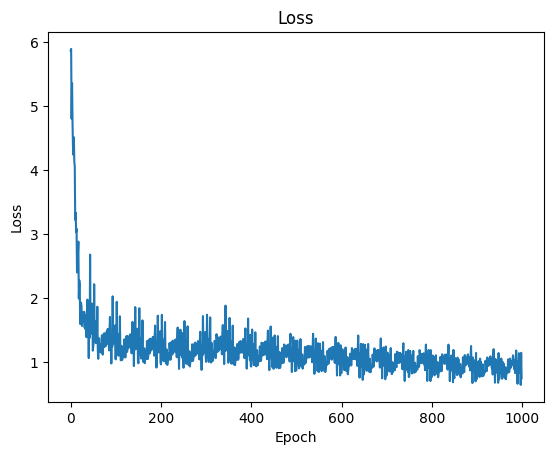

In [ ]:
#print(loss_plot)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_plot)

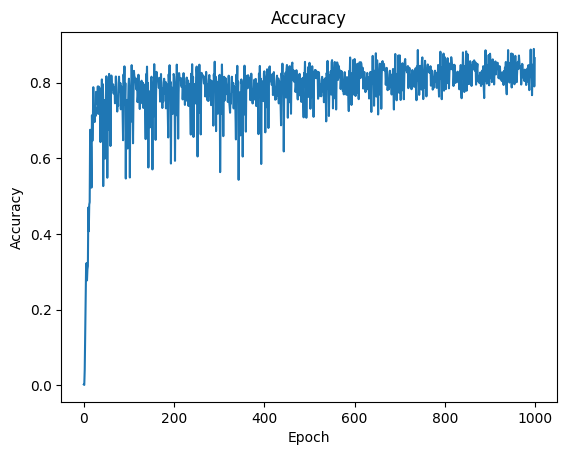

In [ ]:
 plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc_plot)

In [ ]:
pretrained_dict = perPix_model.state_dict()
modelR = DRNSeg(2)    
model_dict=modelR.state_dict()
# filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if
                       (k in model_dict) and (model_dict[k].shape == pretrained_dict[k].shape)}

model_dict.update(pretrained_dict) 
modelR.load_state_dict(model_dict)

device = torch.device(cuda0)
modelR.to(device)


#creates the recreation loss, unwarps image and compares with the original image

b_size=1
my_dataset_reg = TensorDataset(train_x,train_y) # create your datset
my_dataloader_reg = DataLoader(my_dataset_reg,batch_size=b_size)

loss = nn.MSELoss()
def train_regress(epoch):
    for idx,(x_t,y_t) in enumerate(my_dataloader_reg):
      modelR.train()
      tr_loss = 0
      # getting the training set
      x_train, y_train = Variable(x_t), Variable(y_t)
      x_train_orig=Variable(torch.from_numpy(train_x_orig))
      # converting the data into GPU format
      if torch.cuda.is_available():
          x_train = x_train.cuda()
          y_train = y_train.cuda()
          x_train_orig=x_train_orig.cuda()  
     
      optimizer.zero_grad()

      output_train = modelR(x_train.float()).float()
  
      total = train_size
     
 
      MS_loss_train =loss(output_train, y_train.float())
      
      loss_train=MS_loss_train 
      train_losses.append(loss_train)
      
      # computing the updated weights of all the model parameters
      loss_train.backward()
      optimizer.step()
      tr_loss = loss_train.item()

      if epoch%10 == 0:
          # printing the validation loss
          print('Epoch : ',epoch+1, "for Batch:",idx, '\t', 'loss :',tr_loss)
          
          print("\n")

In [ ]:
n_epochs = 10
train_losses =[]
correct =0
#same parameters the FAL paper have used
optimizer = Adam(modelR.parameters(),lr=0.001,betas =(0.9,0.999)) 
for epoch in range(n_epochs): 
    train_regress(epoch)

Epoch :  1 for Batch: 0 	 loss : 550.8685302734375


Epoch :  1 for Batch: 1 	 loss : 1743.4132080078125


Epoch :  1 for Batch: 2 	 loss : 1330.34814453125


Epoch :  1 for Batch: 3 	 loss : 558.842529296875


Epoch :  1 for Batch: 4 	 loss : 237.02154541015625


Epoch :  1 for Batch: 5 	 loss : 306.9606018066406


Epoch :  1 for Batch: 6 	 loss : 143.61289978027344


Epoch :  1 for Batch: 7 	 loss : 284.6997985839844


Epoch :  1 for Batch: 8 	 loss : 228.82057189941406


Epoch :  1 for Batch: 9 	 loss : 202.1605987548828


Epoch :  1 for Batch: 10 	 loss : 165.83941650390625


Epoch :  1 for Batch: 11 	 loss : 56.474849700927734


Epoch :  1 for Batch: 12 	 loss : 105.68919372558594


Epoch :  1 for Batch: 13 	 loss : 66.61836242675781


Epoch :  1 for Batch: 14 	 loss : 161.9564208984375


Epoch :  1 for Batch: 15 	 loss : 130.48536682128906


Epoch :  1 for Batch: 16 	 loss : 152.79718017578125


Epoch :  1 for Batch: 17 	 loss : 200.3338165283203


Epoch :  1 for Batch: 18 	 loss

In [ ]:
from FALdetector.utils.visualize import *
from utils.tools import *
from utils.visualize import *

In [ ]:
#function to
def get_heatmap_cv(img, magn, max_flow_mag):
    min_flow_mag = 5
    cv_magn = np.clip(
        255 * (magn - min_flow_mag) / (max_flow_mag - min_flow_mag),
        a_min=0,
        a_max=255).astype(np.uint8)
    if img.dtype != np.uint8:
        img = (255 * img).astype(np.uint8)
        
    heatmap_img = cv2.applyColorMap(cv_magn, cv2.COLORMAP_MAGMA)
    heatmap_img = heatmap_img[..., ::-1]
    h, w = magn.shape
    img_alpha = np.ones((h, w), dtype=np.double)[:, :, None]
    heatmap_alpha = np.clip(
        magn / max_flow_mag, a_min=0, a_max=1)[:, :, None]**.7
    heatmap_alpha[heatmap_alpha < .2]**.5
    pm_hm = heatmap_img * heatmap_alpha
    pm_img = img * img_alpha
    cv_out = pm_hm + pm_img * (1 - heatmap_alpha)
    cv_out = np.clip(cv_out, a_min=0, a_max=255).astype(np.uint8)
    return cv_out

def save_heatmap_cv(img, magn, path, max_flow_mag=2):
    cv_out = get_heatmap_cv(img, magn, max_flow_mag)
    out = Image.fromarray(cv_out)
    plt.imshow(out)
    plt.show()
    out.save(path, quality=95)
    return out

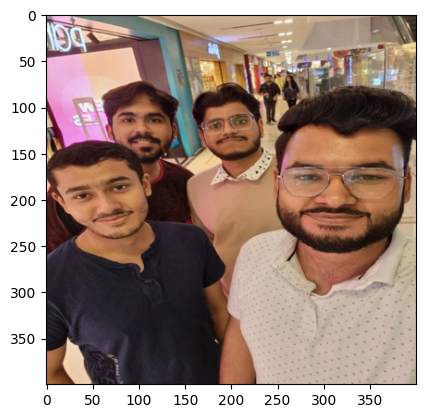

(1, 400, 400, 3)
(1, 3, 400, 400)
perpixel original shape (1, 400, 400)
(2, 400, 400)
[[[ 0.17900105  0.21877906  0.25855708 ... -0.61097646 -0.5169801
   -0.4229837 ]
  [ 0.21877906  0.26739663  0.3160142  ... -0.74674904 -0.63186455
   -0.5169801 ]
  [ 0.25855708  0.3160142   0.37347132 ... -0.88252157 -0.74674904
   -0.61097646]
  ...
  [ 0.37753072  0.46142644  0.5453221  ... -0.67188317 -0.56851655
   -0.46514988]
  [ 0.31944907  0.39043775  0.46142644 ... -0.56851655 -0.48105246
   -0.39358836]
  [ 0.2613674   0.31944907  0.37753072 ... -0.46514988 -0.39358836
   -0.32202685]]

 [[ 0.08236571  0.1006692   0.11897269 ...  0.32510024  0.27508482
    0.2250694 ]
  [ 0.1006692   0.12304013  0.14541106 ...  0.39734477  0.33621478
    0.27508482]
  [ 0.11897269  0.14541106  0.17184944 ...  0.46958926  0.39734477
    0.32510024]
  ...
  [-0.36818728 -0.4500067  -0.5318261  ... -0.5749068  -0.48645964
   -0.39801243]
  [-0.31154308 -0.3807749  -0.4500067  ... -0.48645964 -0.4116197
   -0

In [ ]:
# test_ref = X_ref[1]
# test_mod = X_mod[1]




# print(test_mod.shape)
def load_data(img_path, device):
    face = Image.open(img_path).convert('RGB')
    face = face.resize((400,400))
    face_tens = tf(face).to(device)
    return face_tens, face
'''
pathM ="/content/modif/modified/rider-1.jpg"
pathR ="/content/ref/reference/rider-1.jpg" 
'''
pathR="/content/original.jpeg"
pathM="/content/modified.jpeg"
X_ref=createTrain(pathR,train_size)
X_mod = createTrain(pathM,train_size)


imgR, modified = load_data(r""+pathM, device)
imgR_ref, reference = load_data(r""+pathR, device)
test_ref= np.array(Image.open(r""+pathR).resize( (width, height)))
test_mod= np.array(Image.open(r""+pathM).resize( (width, height)))
plt.imshow(test_mod)
plt.show()


ground_flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(test_ref,cv2.COLOR_BGR2GRAY), cv2.cvtColor(test_mod,cv2.COLOR_BGR2GRAY),None, 0.5, 3, 4, 2, 3, 1.2, 0)
image = np.array([test_mod])

shapes = image.shape
print(shapes)
image = np.transpose(image,(0,3,1,2))
print(image.shape)
image_tensor = torch.from_numpy(image)
image_tensor= Variable(image_tensor)
# converting the data into GPU format
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()


#ground_flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(test_ref,cv2.COLOR_BGR2GRAY), cv2.cvtColor(test_mod,cv2.COLOR_BGR2GRAY),None, 0.5, 3, 4, 2, 3, 1.2, 0)

with torch.no_grad():
        flow = perPix_model(image_tensor.float()).cpu().numpy()
        
        flow = np.argmax(flow,1)
        print("perpixel original shape",flow.shape)
        flow =flow[0]
        #print(flow.shape)
        #print(flow)
        real_flow = np.zeros((2,400,400))
        temp =0
        for i in range(shapes[1]):
          for j in range(shapes[2]):
            real_flow[:,i,j]=inv_dic[int(flow[i][j])]
        #print(real_flow.shape)
        np.set_printoptions(edgeitems=3)
        #print(real_flow)
        real_flow = np.transpose(real_flow, (1, 2, 0))
      
        flow_reg = modelR(imgR.unsqueeze(0))[0].cpu().numpy()
        print(flow_reg.shape)
        print(flow_reg)
        flow_reg = np.transpose(flow_reg, (1, 2, 0))
        print(flow_reg.shape)
        w, h, _ = real_flow.shape

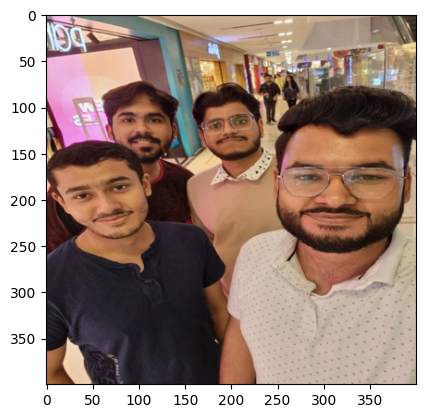

<ipython-input-20-c56ae5c8916f>:5: RuntimeWarning: divide by zero encountered in true_divide
  255 * (magn - min_flow_mag) / (max_flow_mag - min_flow_mag),


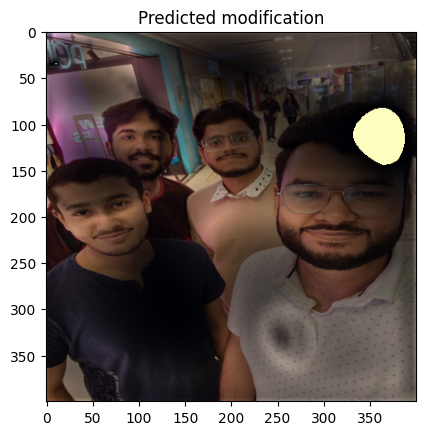

<ipython-input-20-c56ae5c8916f>:5: RuntimeWarning: invalid value encountered in true_divide
  255 * (magn - min_flow_mag) / (max_flow_mag - min_flow_mag),


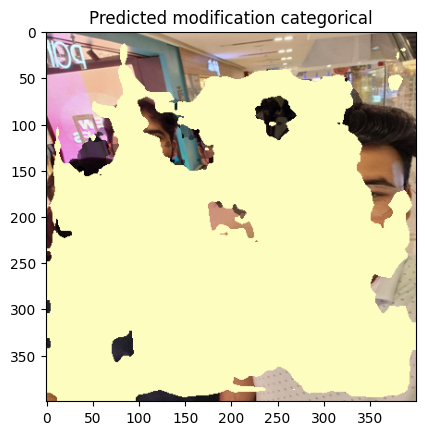

In [ ]:

flow = flow_resize(flow_reg, modified.size)
flow_categ = flow_resize(real_flow, modified.size)
plt.imshow(modified)
modified_np = np.array(modified)
plt.show()
mag, ang = cv2.cartToPolar(flow[:,:,1], flow[:,:,0])
mag_c, ang = cv2.cartToPolar(flow_categ[:,:,0], flow_categ[:,:,1])
path = "tester.png"
tester =get_heatmap_cv(modified_np,mag,max_flow_mag=5)
plt.title("Predicted modification")
plt.imshow(tester)
plt.show()
tester2 =get_heatmap_cv(modified_np,mag_c,max_flow_mag=5)
plt.title("Predicted modification categorical")
plt.imshow(tester2)



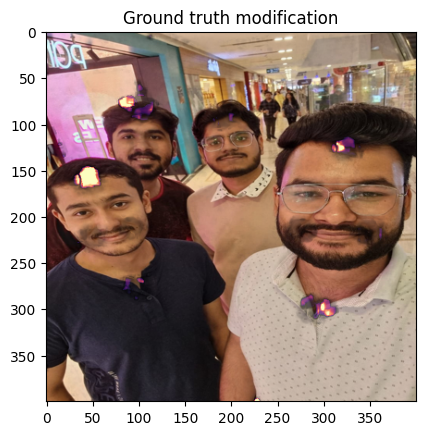

In [ ]:

mag, ang = cv2.cartToPolar(ground_flow[...,0], ground_flow[...,1])
#print(mag.shape)

real = get_heatmap_cv(np.array(reference),mag,max_flow_mag=12)
plt.title("Ground truth modification")
plt.imshow(real)